In [316]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import compress
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import os
from rdb_functions import generate_b1_b0
from rdb_functions import fill_nas


def zero_plus(item,digits):
    i=str(item)
    zeros=digits-len(i)
    return zeros*'0'+i


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Loading data

# Data from 2020

In [126]:
path=f'/Volumes/TOSHIBA EXT/BootCamp/Datos/inegi'
os.listdir(path)

# Reading all the information

files=[ 'sociodem_13_15_2020.csv',
 'sociodem_21_14_2020.csv',
 'sociodem_31_19_2020.csv']

data_20=pd.read_csv(path+'/'+'sociodem_13_09_2020.csv')

for file in files:
    aux=pd.read_csv(path+'/'+file)
    data_20=data_20.append(aux)
    
data_20.reset_index(inplace=True,drop=True)

data_20['id']=[zero_plus(i,13) for i in data_20['id']]

path=f'/Volumes/TOSHIBA EXT/BootCamp/Datos/MetrosCubicos/'

prices=pd.read_csv(path+'precios_13.csv')

for i in ['21','31']:
    aux=pd.read_csv(path+f'precios_{i}.csv')
    prices=prices.append(aux)

data_20=prices.merge(data_20,how='left',on=['id','clave'],indicator=True)

data_20=data_20[data_20['_merge']=='both']
data_20.shape

In [185]:
b=set(data_20.id.unique())
ids=a.intersection(b)

cl=[i in ids for i in data_20.id]
print(data_20.shape)
data_10=data_20[cl]
print(data_20.shape)

(2947, 16)
(2947, 16)


In [193]:
data_20.sort_values('id',inplace=True)

In [242]:
data_20=data_20[~data_10.pobtot.isna()]

In [243]:
X_20=data_20[['pobtot','vph_pc',
 'pct_wf',
 'pct_hh_car',
 'pct_hh_pc']]

y=data_20.p_m

## Splitting in train and test

In this section we split the data in test data and train data. We did this because in further analysys the idea is to tune the hyperparameters to have better estimators.

In [244]:
for column in list(X_20):
    b1_b0=generate_b1_b0(X_20,'pobtot',column)
    X_20[column]=fill_nas(X_20[column],X_20['pobtot'],b1_b0)

<ipython-input-244-8bd2ef6f9e7a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_20[column]=fill_nas(X_20[column],X_20['pobtot'],b1_b0)
<ipython-input-244-8bd2ef6f9e7a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_20[column]=fill_nas(X_20[column],X_20['pobtot'],b1_b0)
<ipython-input-244-8bd2ef6f9e7a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [245]:
X_20.drop(columns='pobtot',inplace=True)

/Users/rafa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [246]:
X_train, X_test, y_train, y_test = train_test_split(X_20, y, test_size=0.33, random_state=42)

In [247]:
corlist=['p_m']
corlist.extend(list(X_20))

### Showing correlation between variables in a heatmap

<AxesSubplot:>

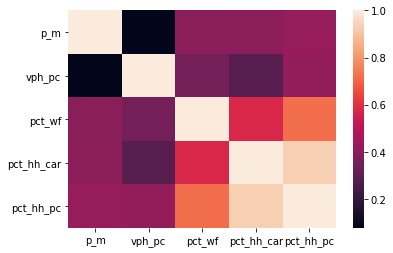

In [248]:
sns.heatmap((data[corlist]).corr())

### Gradient Boosting Regressor

In the next step we estimate the price in 2010, we used a Gradient Boosting Regressor just to get familiar with the model, there was no particular reason to use this model besides their good properties, the parameters were by default. In further analysis these parameters are going to be optimized.

In [249]:
gbr = GradientBoostingRegressor(
learning_rate=0.1,
n_estimators=200,
subsample=0.6,
random_state=42)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=200, random_state=42, subsample=0.6)

In [317]:
# Error test
# ==============================================================================
predicciones = gbr.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 6660.566938538847


In [318]:
y.describe()

count     2780.000000
mean     15473.118343
std       7444.378062
min       5363.941176
25%       9820.595682
50%      13294.779377
75%      19869.304291
max      38759.689922
Name: p_m, dtype: float64

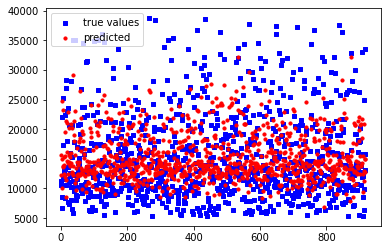

In [327]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.scatter(range(len(y_test)),y_test, s=10, c='b', marker="s", label='true values')
plt.scatter(range(len(y_test)),predicciones, s=10, c='r', marker="o", label='predicted')
plt.legend(loc='upper left');
plt.show()

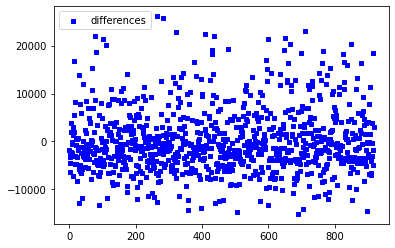

In [328]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.scatter(range(len(y_test)),y_test-predicciones, s=10, c='b', marker="s", label='differences')
plt.legend(loc='upper left');
plt.show()

The follow code shows the prediction weight of each variable.

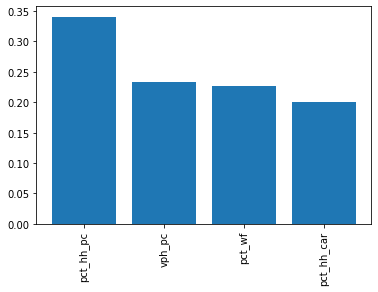

In [250]:
# feature importances from random forest model
importances = gbr.feature_importances_
# index of greatest to least feature importances
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))
# create tick labels
feature_names=list(X_20)
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)
# rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

In this part we predict the prices in 2010. 

In [251]:
path=f'/Volumes/TOSHIBA EXT/BootCamp/Datos/inegi'
os.listdir(path)

files=[ 'sociodem_13_15_2010.csv',
 'sociodem_21_14_2010.csv',
 'sociodem_31_19_2010.csv']

data_10=pd.read_csv(path+'/'+'sociodem_13_09_2010.csv')

for file in files:
    aux=pd.read_csv(path+'/'+file)
    data_10=data_10.append(aux)
    
data_10.reset_index(inplace=True,drop=True)


data_10['id']=[zero_plus(i,13) for i in data_10['id']]

data_10=prices[['clave','id','zm']].merge(data_10,how='left',on=['clave','id'])

a=set(data_10.id.unique())

data_10.sort_values('id',inplace=True)

cl=[i in ids for i in data_10.id]
print(data_10.shape)
data_10=data_10[cl]
print(data_10.shape)

(2953, 14)
(2947, 14)
pobtot        167
vph_pc        167
pct_wf        183
pct_hh_car    180
pct_hh_pc     180
dtype: int64


<ipython-input-251-4e31c6fe3480>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_10[column]=fill_nas(X_10[column],X_10['pobtot'],b1_b0)
<ipython-input-251-4e31c6fe3480>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_10[column]=fill_nas(X_10[column],X_10['pobtot'],b1_b0)
<ipython-input-251-4e31c6fe3480>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

pobtot        167
vph_pc        167
pct_wf        167
pct_hh_car    167
pct_hh_pc     167
dtype: int64


<ipython-input-251-4e31c6fe3480>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_10[column]=fill_nas(X_10[column],X_10['pobtot'],b1_b0)
<ipython-input-251-4e31c6fe3480>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_10[column]=fill_nas(X_10[column],X_10['pobtot'],b1_b0)


In [253]:
data_10=data_10[~data_10.pobtot.isna()]

In [254]:
print(data_10.shape)
print(data_20.shape)

(2780, 14)
(2780, 16)


In [255]:
data_20.tail()

,clave,id,p_m,zm,loc,ageb,pobtot,pocupada_f,pocupada,vph_autom,vivtot,vph_pc,pct_wf,pct_hh_car,pct_hh_pc,_merge
2947,19049,1904900010491,13372.675929,31,1.0,0491,1174.0,167.249642,511.804092,236.056487,432.0,109.229970,32.678449,54.642705,25.284715,both
2948,19049,1904900010504,22300.000000,31,1.0,0504,639.0,112.492265,280.764567,160.627790,254.0,111.900274,40.066404,63.239287,44.055226,both
2949,19049,1904900010557,29750.000000,31,1.0,0557,141.0,32.033016,74.386231,38.946698,102.0,16.820291,43.063099,38.183037,16.490481,both
2950,19049,1904900010561,15294.117647,31,1.0,0561,828.0,144.843153,396.442189,115.878357,211.0,59.809893,36.535757,54.918652,28.345921,both
2951,19049,1904900010580,22114.988827,31,1.0,0580,24.0,4.000000,9.000000,4.000000,24.0,4.393622,44.444444,16.666667,18.306760,both


In [257]:
X_10=data_10[['pobtot','vph_pc',
 'pct_wf',
 'pct_hh_car',
 'pct_hh_pc']]

print(X_10.isna().sum())

for column in list(X_10):
    b1_b0=generate_b1_b0(X_10,'pobtot',column)
    X_10[column]=fill_nas(X_10[column],X_10['pobtot'],b1_b0)
    
print(X_10.isna().sum())

pobtot         0
vph_pc         0
pct_wf        16
pct_hh_car    13
pct_hh_pc     13
dtype: int64


<ipython-input-257-fd6573f98a6e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_10[column]=fill_nas(X_10[column],X_10['pobtot'],b1_b0)
<ipython-input-257-fd6573f98a6e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_10[column]=fill_nas(X_10[column],X_10['pobtot'],b1_b0)
<ipython-input-257-fd6573f98a6e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

pobtot        0
vph_pc        0
pct_wf        0
pct_hh_car    0
pct_hh_pc     0
dtype: int64


<ipython-input-257-fd6573f98a6e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_10[column]=fill_nas(X_10[column],X_10['pobtot'],b1_b0)
<ipython-input-257-fd6573f98a6e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_10[column]=fill_nas(X_10[column],X_10['pobtot'],b1_b0)


In [258]:
X_10.drop(columns=['pobtot'],inplace=True)
    
gbr.predict(X_10)
    
growth=100*(y/gbr.predict(X_10))-100

predictions=pd.DataFrame({'precio m2 2010 predicted':gbr.predict(X_10),
               'precio m2 2020':y,
               'growth':growth})

/Users/rafa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [259]:
data_10['growth']=growth
results=data_10[['id','growth']]

In [300]:
data_10.head(2)

,clave,id,zm,loc,ageb,pobtot,pocupada_f,pocupada,vph_autom,vivtot,vph_pc,pct_wf,pct_hh_car,pct_hh_pc,growth
0,9002,0900200010148,13,1.0,0148,2645.0,465.779620,1078.848699,535.425071,794.0,483.25067,43.173767,67.433888,60.862805,-8.250909
1,9002,0900200010260,13,1.0,0260,5150.0,646.063037,1452.000000,528.000000,1408.0,637.00000,44.494699,37.500000,45.241477,-43.889553


In [302]:
data_grouped=data_10[['zm','clave','growth']].groupby(['zm','clave'],as_index=False).mean()

In [321]:
data_10[['zm','clave','growth']].groupby(['zm','clave'],as_index=False).mean()

,zm,clave,growth
0,13,9002,2.281499
1,13,9003,11.477190
2,13,9004,123.741089
3,13,9005,19.255866
4,13,9006,7.277295
5,13,9007,10.427923
6,13,9008,78.179173
7,13,9009,10.152592
8,13,9010,37.739068
9,13,9011,5.899492


In [323]:
data_10[data_10['clave']==14051]

,clave,id,zm,loc,ageb,pobtot,pocupada_f,pocupada,vph_autom,vivtot,vph_pc,pct_wf,pct_hh_car,pct_hh_pc,growth
1727,14051,1405100010162,21,1.0,0162,267.0,34.478588,90.142292,32.850457,60.0,13.09441,38.249069,54.750761,21.824017,98.661224


In [313]:
data_grouped.head(2)

,zm,clave,growth,CVE_ENT,CVE_MUN
0,13,9002,2.281499,09,002
1,13,9003,11.477190,09,003


In [306]:
data_grouped['CVE_ENT']=[zero_plus(str(round(i/1000)),2) for i in data_grouped['clave']]

In [309]:
data_grouped['CVE_MUN']=[zero_plus(str(i%1000),3) for i in data_grouped['clave']]

In [314]:
for i in [13,21,31]:
    aux=data_grouped[data_grouped['zm']==i]
    aux.to_csv(path+'/'+f'growth_{i}.csv',index=False)

In [260]:
predictions.describe()

,precio m2 2010 predicted,precio m2 2020,growth
count,2780.000000,2780.000000,2780.000000
mean,13924.599090,15473.118343,14.478806
std,4062.338663,7444.378062,52.484046
min,6077.744169,5363.941176,-83.257447
25%,11020.047236,9820.595682,-22.541021
50%,13222.488804,13294.779377,5.721540
75%,15652.273408,19869.304291,41.136640
max,39308.158640,38759.689922,370.399066


We decided to show only movements that we didn't consider outliers. 

# Percentage increase distribution in $price/m^2$ in Benito Juarez

1515
2780


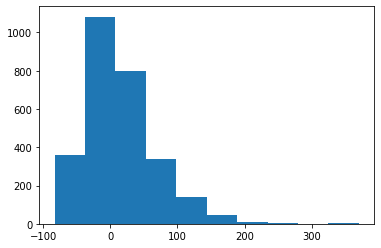

In [261]:
plt.hist(results['growth'])
print((results['growth']>0).sum())
print(len(results['growth']))

In [262]:
results.shape

(2780, 2)

### Exporting the results of the model to visualize the results.

In [264]:
results.to_csv(path+'/results.csv',index=False)

In the next plots we analyzed how the percentages changed in percentual points.

Percentual points change in vph_pc


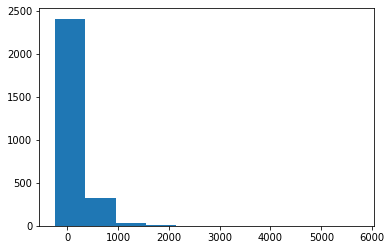

Percentual points change in pct_wf


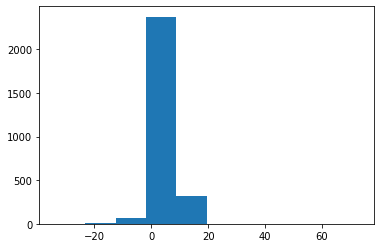

Percentual points change in pct_hh_car


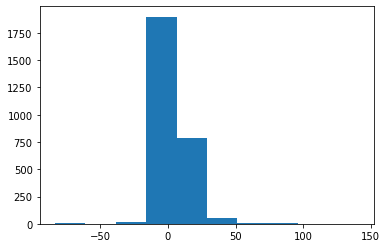

Percentual points change in pct_hh_pc


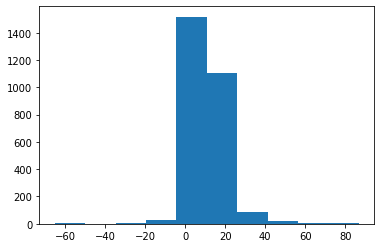

In [263]:
for column in list(X_20):
    change=X_20[column]-X_10[column]

    print(f'Percentual points change in {column}')
    plt.hist(change)
    plt.show()

In [298]:
import geopandas as gpd

zm='13'
zm=gpd.read_file(f'/Volumes/TOSHIBA EXT/BootCamp/Shapes/zms/zm_{zm}_growth.shp')
#zm['growth'][zm['growth'].isna()]=0

In [275]:
for zm_n in ['13','21','31']:

    zm=gpd.read_file(f'/Volumes/TOSHIBA EXT/BootCamp/Shapes/zms/zm_{zm_n}.shp')
    print(zm.shape)
    zm=zm.merge(results,how='left',left_on='CVEGEO', right_on='id')
    print(zm.shape)
    zm.to_file(f'/Volumes/TOSHIBA EXT/BootCamp/Shapes/zms/zm_{zm_n}_growth.shp')
    zm.to_file(f"/Volumes/TOSHIBA EXT/BootCamp/Shapes/zms/zm_{zm_n}.geojson", driver='GeoJSON')

(5770, 8)
(5770, 10)
(1992, 8)
(1992, 10)
(2012, 8)
(2012, 10)


In [278]:
zm.head()

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,clave,ZM,id,growth,geometry
0,1500200050177,15,2,0005,0177,15002,1,None,NaN,"POLYGON ((-98.88892 19.66129, -98.88900 19.660..."
1,1500200150073,15,2,0015,0073,15002,1,None,NaN,"POLYGON ((-98.90758 19.61170, -98.90784 19.610..."
2,1500200150143,15,2,0015,0143,15002,1,None,NaN,"POLYGON ((-98.95587 19.62465, -98.95506 19.624..."
3,1500200150637,15,2,0015,0637,15002,1,None,NaN,"POLYGON ((-98.98965 19.59113, -98.98978 19.590..."
4,1500200150548,15,2,0015,0548,15002,1,None,NaN,"POLYGON ((-98.97448 19.62163, -98.97447 19.621..."


<AxesSubplot:title={'center':'Price increase'}>

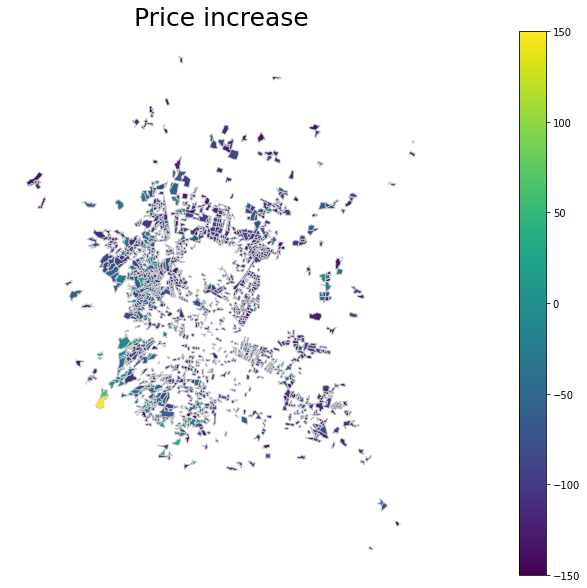

In [299]:
# set the value column that will be visualised
variable = 'growth'
# set the range for the choropleth values
vmin, vmax = -150, 150
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))
# remove the axis
ax.axis('off')
# add a title and annotation
ax.set_title('Price increase', fontdict={'fontsize': '25', 'fontweight' : '3'})
# ax.annotate('Source: Wikipedia - https://en.wikipedia.org/wiki/Provinces_of_Indonesia', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')
# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
fig.colorbar(sm)
# create map
#zm[zm['CVE_ENT']==9].plot(column=variable, cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8')
zm.plot(column=variable, cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8')